In [1]:
"""
Plot t-statistic discriminability (alternative to Fisher info; Figure S2)

"""

import matplotlib.pyplot as plt
import os, sys
import numpy as np
from matplotlib import cm

import matplotlib.lines as mlines

##%% paths
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code', 'analysis_code'))
import load_activations
import plot_utils
colors_main, colors_sf = plot_utils.get_cmaps_biasCNN()
baseline_inds, card_inds, obl_inds, twent_inds = plot_utils.get_fi_bin_pars()

figfolder = os.path.join(root,'figures','Tstat')

In [2]:
# Parameters

# define which network to load (this analysis was only run for pretrained)
training_strs=['pretrained']
ckpt_strs=['0']
nInits_list = [1]
color_inds=[1]

# define other basic parameters
nImageSets = 4
model='vgg16'
param_str='params1'
param_strs=[]
for ii in range(np.max(nInits_list)):    
  if ii>0:
    param_strs.append(param_str+'_init%d'%ii)
  else:
    param_strs.append(param_str)

dataset_str=['FiltIms14AllSFCos'] # this is just the codename for my main filtered image set
nTrainingSchemes = np.size(training_strs)

 # values of "delta" to use for fisher information
delta_vals = np.arange(1,10,1)
nDeltaVals = np.size(delta_vals)

info = load_activations.get_info(model, dataset_str[0])

# this set doesn't have different spat frequency levels, just broadband
sf_labels=['broadband SF']
nSF=1
sf=0

maxfeat = 8640

# how many PCs were combined to compute the measure? 
ncomp2do = [1,2,3,4,5,6,7,8,9,10,20,50,100,500,1000,8640]



In [3]:

#%% load the values for t-statistics (calculated outside this code then saved)
all_tsep = []

# load activations for each training set of images (training schemes)
for tr in range(nTrainingSchemes):
  training_str = training_strs[tr]
  ckpt_num = ckpt_strs[tr]
  dataset_all = dataset_str[0]
  nInits = nInits_list[tr]
  
  # different initializations with same training set
  for ii in range(nInits):
 
    param_str=param_strs[ii]
  
    # different versions of the evaluation image set (samples)
    for kk in range(nImageSets):
           
      if 'Filt' in dataset_all:
        dataset = '%s_rand%d'%(dataset_all,kk+1)
      elif kk==0:
        dataset = dataset_all
      else:
        dataset = '%s%d'%(dataset_all,kk)
        
      if ii==0 and kk==0:
        info = load_activations.get_info(model,dataset)
        layer_labels = info['layer_labels']
        layers2load = info['layer_labels_full']
        nOri = info['nOri']
        ori_axis = np.arange(0, nOri,1)
        
      # find the exact number of the checkpoint 
      ckpt_dirs = os.listdir(os.path.join(root,'saved_analyses','tsep',model,training_str,param_str,dataset))
      ckpt_dirs = [dd for dd in ckpt_dirs if 'eval_at_ckpt-%s'%ckpt_num[0:2] in dd and '_reduced_varyncomps' in dd]
      nums=[dir[np.char.find(dir,'-')+1:np.char.find(dir,'_reduced')] for dir in ckpt_dirs]            
  
      save_path = os.path.join(root,'saved_analyses','tsep',model,training_str,param_str,dataset,'eval_at_ckpt-%s_reduced_varyncomps'%nums[0],'Distance_tstat_vary_ncomps.npy')
      print('loading from %s\n'%save_path)
      # array is [nLayer x nSF x nOri x nDeltaValues] in size
      tsep = np.load(save_path)

      if kk==0 and tr==0 and ii==0:
        nLayers = info['nLayers']         
        nOri = np.shape(tsep)[2]      
        # initialize this ND array to store all Fisher info calculated values
        all_tsep = np.zeros([nTrainingSchemes, np.max(nInits_list), nImageSets, nLayers, nSF, nOri, len(ncomp2do), nDeltaVals])
 
      all_tsep[tr,ii,kk,:,sf,:,:,:] = np.squeeze(tsep);


loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/tsep/vgg16/pretrained/params1/FiltIms14AllSFCos_rand1/eval_at_ckpt-0_reduced_varyncomps/Distance_tstat_vary_ncomps.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/tsep/vgg16/pretrained/params1/FiltIms14AllSFCos_rand2/eval_at_ckpt-0_reduced_varyncomps/Distance_tstat_vary_ncomps.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/tsep/vgg16/pretrained/params1/FiltIms14AllSFCos_rand3/eval_at_ckpt-0_reduced_varyncomps/Distance_tstat_vary_ncomps.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/tsep/vgg16/pretrained/params1/FiltIms14AllSFCos_rand4/eval_at_ckpt-0_reduced_varyncomps/Distance_tstat_vary_ncomps.npy



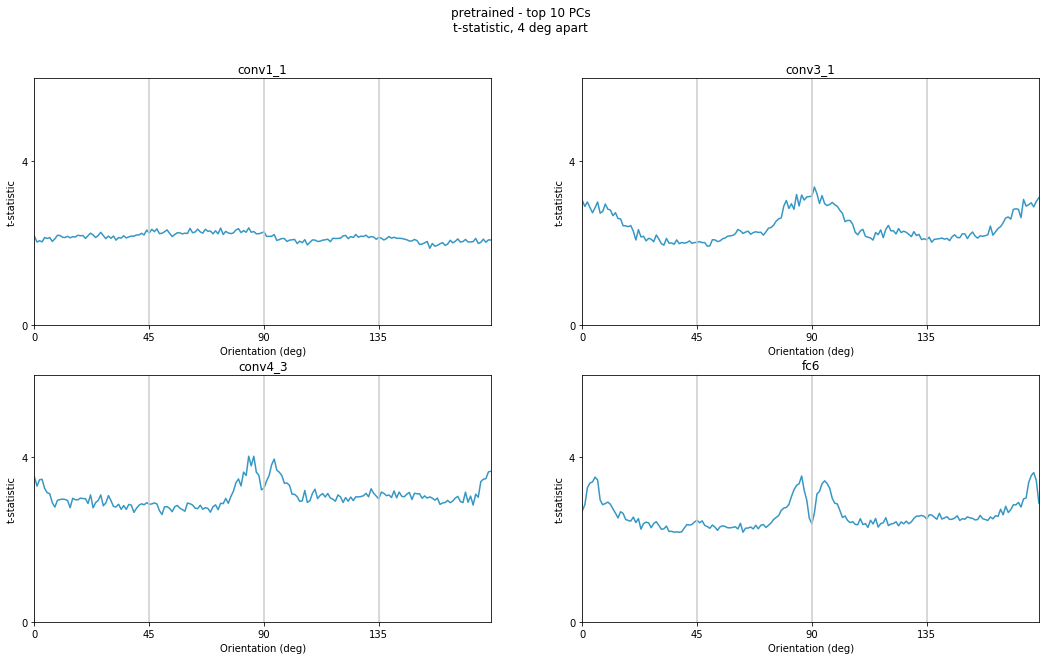

In [4]:
# Plot t-statistic distance as a function of orient, for several example layers.

# Figure S2A.

ncomp2do = [1,2,3,4,5,6,7,8,9,10,20,50,100,500,1000,8640]

nn=9

layers2plot = np.asarray([0,6,12,18])

tr2plot=[0] 

init2plot = [0]
cols_grad = cm.Blues(np.linspace(0,1,6))
cols_grad=cols_grad[2:,:]

ii=0

dd=3
#ii=1
plt.rcParams['pdf.fonttype']=42
plt.rcParams.update({'font.size': 10})
plt.rcParams['ps.fonttype']=42    
plt.rcParams['figure.figsize']=[18,10]
ylimits = [0,6]
plt.close('all')

plt.figure()
npx = np.ceil(np.sqrt(np.size(layers2plot)))
npy = np.ceil(np.size(layers2plot)/npx)

# loop over layers, making a subplot for each
for ll in range(np.size(layers2plot)):

  plt.subplot(npx,npy, ll+1)
  
  for tr in tr2plot:
  
    vals_all = np.zeros([nImageSets,nOri])
    
    for kk in range(nImageSets):
      
      vals= np.squeeze(all_tsep[tr,ii,kk,layers2plot[ll],sf,:,nn,dd])
      vals_all[kk,:] = vals

  # average over image sets
    meanvals = np.mean(vals_all,0)    
    errvals = np.std(vals_all,0)

#     plt.errorbar(ori_axis,meanvals,errvals,ecolor=colors_main[color_inds[tr],:],color=[0,0,0])
    plt.plot(ori_axis,meanvals,color=colors_main[color_inds[tr],:])
    
  # finish up this subplot    
  plt.title('%s' % (layer_labels[layers2plot[ll]]))

  plt.xlabel('Orientation (deg)')
  plt.xticks(np.arange(0,181,45))
  plt.xlim([np.min(ori_axis),np.max(ori_axis)])
  plt.ylabel('t-statistic')


  for xx in np.arange(0,181,45):
      plt.axvline(xx,color=[0.8, 0.8, 0.8])
  plt.ylim(ylimits)
  plt.yticks([0,4])
# finish up the entire plot   
plt.suptitle('%s - top %d PCs\nt-statistic, %d deg apart'% (training_strs[tr], ncomp2do[nn], delta_vals[dd]))
figname = os.path.join(figfolder, 't-stat_pretrained_%dcomps.pdf'%ncomp2do[nn])
plt.savefig(figname, format='pdf',transparent=True)



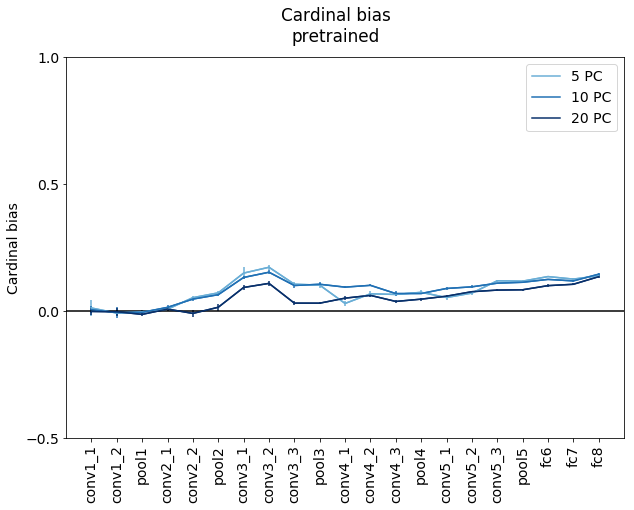

In [6]:
#%% Plot the  cardinal bias across layers, for different ncomponents overlaid. 

# Figure S2C

ncomp2do = [1,2,3,4,5,6,7,8,9,10,20,50,100,500,1000,8640]
nn2plot = [4,9,10]
plt.rcParams.update({'font.size': 14})
plt.close('all')
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
handles = []
layers2plot = np.arange(0,nLayers,1)
sf=0
dd=3
tr=0
cols_grad = cm.Blues(np.linspace(0,1,len(nn2plot)+2))
cols_grad=cols_grad[2:,:]


for nn in range(len(nn2plot)):
  
  
  all_vals = np.zeros([nInits,nImageSets,np.size(layers2plot)])
  
  # loop over network layers
  for ww1 in range(np.size(layers2plot)):
    # loop over network initializations
    for ii in range(nInits):
      # loop over image sets
      for kk in range(nImageSets):
        
        vals= all_tsep[tr,ii,kk,layers2plot[ww1],sf,:,nn2plot[nn],dd]
       
        base_discrim=  vals[baseline_inds]
        peak_discrim = vals[card_inds]
        
        all_vals[ii,kk,ww1] = (np.mean(peak_discrim) - np.mean(base_discrim))/(np.mean(peak_discrim) + np.mean(base_discrim))
      
  # averaging over image sets here
  vals = np.mean(np.mean(all_vals,0),0)
  errvals = np.std(np.mean(all_vals,0),0)

  myline = mlines.Line2D(np.arange(0,np.size(layers2plot),1),vals,color = cols_grad[nn,:])
  ax.add_line(myline)   
  handles.append(myline)
  plt.errorbar(np.arange(0,np.size(layers2plot),1),vals,errvals,color=cols_grad[nn,:])

# finish up this subplot 
ylims = [-0.5,1]
xlims = [-1, np.size(layers2plot)]

plt.legend(['%d PC'%ncomp2do[nn] for nn in nn2plot],loc='upper right')

plt.plot(xlims, [0,0], 'k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.yticks([-0.5,0, 0.5,1])
plt.ylabel('Cardinal bias')
plt.xticks(np.arange(0,np.size(layers2plot),1),[layer_labels[ii] for ii in layers2plot],rotation=90)

# finish up the entire plot
plt.suptitle('Cardinal bias\n%s'%(training_strs[tr]))  
fig.set_size_inches(10,7)
figname = os.path.join(figfolder, 'tsep_pretrained_varyncomps.pdf')
plt.savefig(figname, format='pdf',transparent=True)

